# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2024-11-12 19:48:10--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2024-11-12 19:48:11--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=manja-vitolic-gKXKBY-C-Dk-unsplash.jpg [following]
--2024-11-12 19:48:11--  https://images.un

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 99.9MB/s]


Predicted class: Egyptian cat


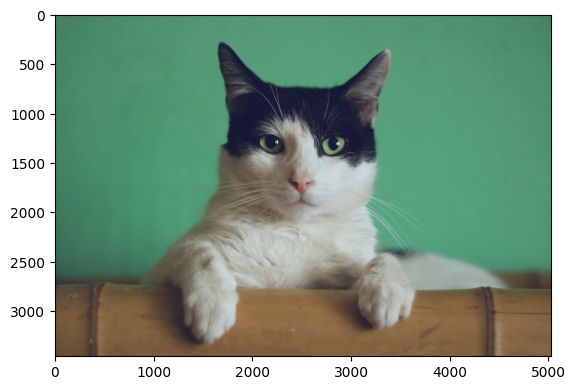

In [ ]:
nameim = "cat"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])

# Expand mu & sigma to match image size
# YOUR CODE HERE
mu = mu.view(3,1,1)
sigma = sigma.view(3,1,1)

# compute the normalized image with mean ImageNet image
img = torch.Tensor(img)
img = (img - mu) / sigma

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval() # WHY THAT ?

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
with torch.no_grad():
   y = vgg16(x) # TODO calcul forward
y = y.numpy() # transformation en array numpy

# Get prediction (i.e., ImageNet class label)
# YOUR CODE HERE
predicted_class = np.argmax(y)
print('Predicted class:', imagenet_classes[predicted_class])

Predicted class: wire-haired fox terrier


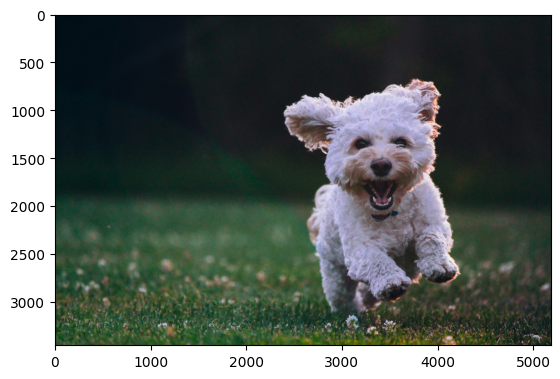

In [ ]:
# 选择 dog.jpg 进行测试
nameim_2 = "dog"+".jpg"
img_2 = Image.open(nameim_2)
plt.imshow(img_2)

# Normalization
img_2 = img_2.resize((224, 224), Image.BILINEAR)
img_2 = np.array(img_2, dtype=np.float32) / 255
img_2 = img_2.transpose((2, 0, 1))

# Expand mu & sigma to match image size

# compute the normalized image with mean ImageNet image
img_2 = torch.Tensor(img_2)
img_2 = (img_2 - mu) / sigma

# Forward pass on VGG
img_2 = np.expand_dims(img_2, 0)
x = torch.Tensor(img_2)
with torch.no_grad():
    y = vgg16(x)
y = y.numpy()

# Get prediction (i.e., ImageNet class label)
# YOUR CODE HERE
predicted_class = np.argmax(y)
print('Predicted class:', imagenet_classes[predicted_class])

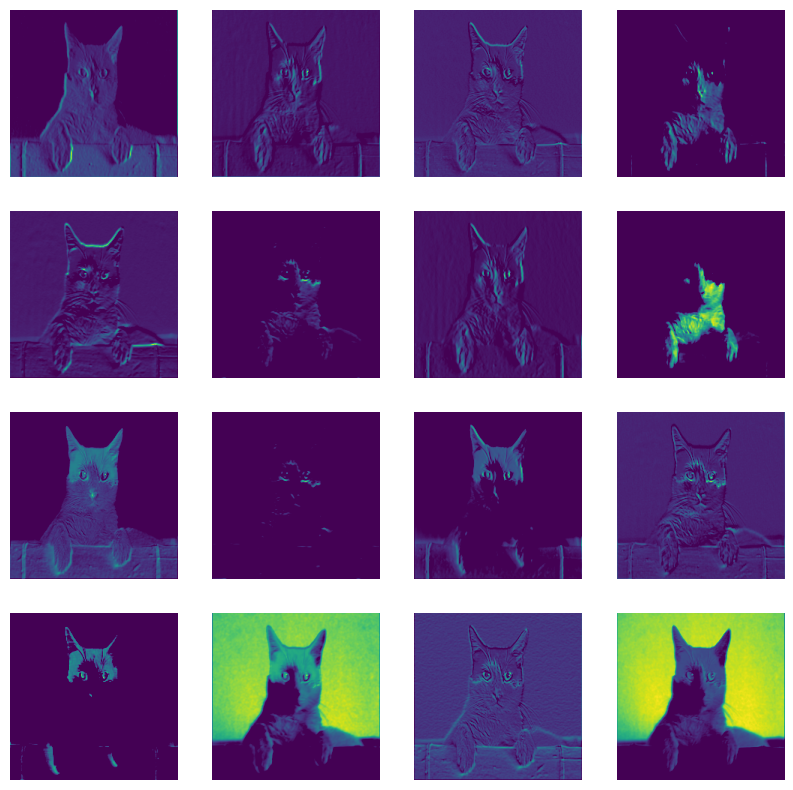

In [ ]:
# Bonus: 可视化第一卷积层的激活图

# 加载 VGG16 模型
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()

# 定义 hook 来捕获第一卷积层的激活图
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# 在 VGG16 的第一卷积层上注册 hook
vgg16.features[0].register_forward_hook(get_activation('conv1'))

# 加载并预处理图像
img_1 = Image.open('cat.jpg')
preposses = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mu, std=sigma)
])
img_1_tensor = preposses(img_1).unsqueeze(0)   # 添加 batch 维度

# 前向传播
with torch.no_grad():
    output = vgg16(img_1_tensor)

# 获取第一卷积层的激活图
act = activation['conv1'].squeeze(0)  # 去除 batch 维度

# 可视化激活图中的若干通道
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < act.shape[0]:  # 确保索引不超出 channel 数量
        ax.imshow(act[i].cpu().numpy(), cmap='viridis')  # 使用 colormap 可视化
        ax.axis('off')

plt.show()

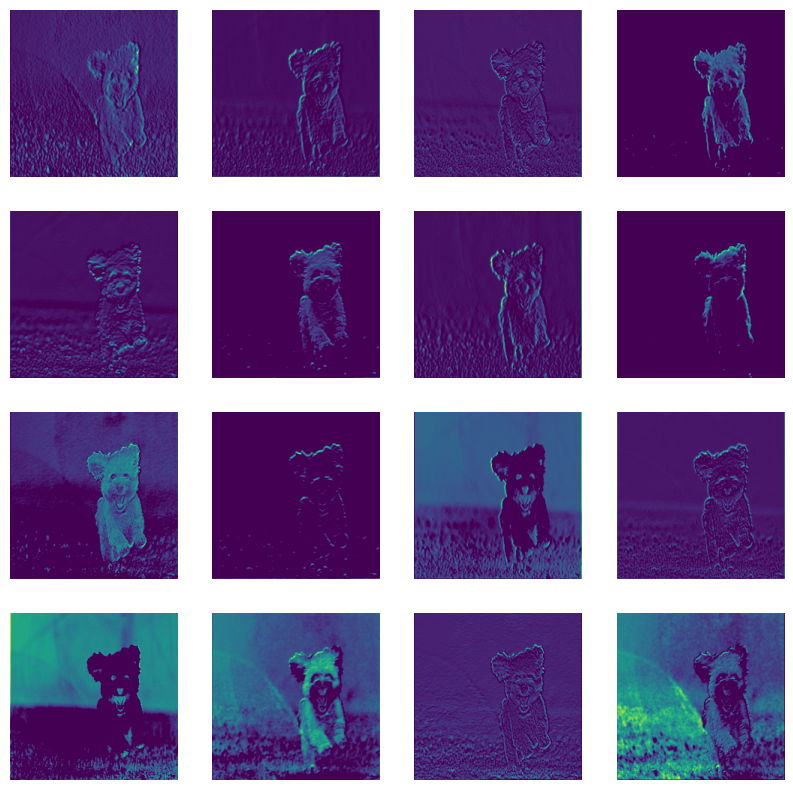

In [ ]:
# 可视化 dog.jpg 的激活图

# 清空 activation
activation = {}

# 加载并预处理图像
img_2 = Image.open('dog.jpg')
preposses = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mu, std=sigma)
])
img_2_tensor = preposses(img_2).unsqueeze(0)   # 添加 batch 维度

# 前向传播
with torch.no_grad():
    output = vgg16(img_2_tensor)

# 获取第一卷积层的激活图
act = activation['conv1'].squeeze(0)  # 去除 batch 维度

# 可视化激活图中的若干通道
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < act.shape[0]:  # 确保索引不超出 channel 数量
        ax.imshow(act[i].cpu().numpy(), cmap='viridis')  # 使用 colormap 可视化
        ax.axis('off')

plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2024-11-12 19:48:58--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2024-11-12 19:48:58--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   345MB/s    in 0.2s    

2024-11-12 19:48:58 (345 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520868]

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0035.jpg  image_0068.jpg  image_0103.jpg  image_0141.jpg  image_0182.jpg
image_0004.jpg  image_0037.jpg  image_0069.jpg  image_0104.jpg  image_0142.jpg  image_0189.jpg
image_0006.jpg  image_0039.jpg  image_0071.jpg  image_0112.jpg  image_0144.jpg  image_0190.jpg
image_0007.jpg  image_0040.jpg  image_0073.jpg  image_0113.jpg  image_0148.jpg  image_0191.jpg
image_0008.jpg  image_0042.jpg  image_0074.jpg  image_0114.jpg  image_0150.jpg  image_0192.jpg
image_0011.jpg  image_0043.jpg  image_0077.jpg  image_0115.jpg  image_0152.jpg  image_0195.jpg
image_0013.jpg  image_0047.jpg  image_0080.jpg  image_0117.jpg  image_0153.jpg  image_0196.jpg
image_0014.jpg  image_0049.jpg  image_0081.jpg  image_0118.jpg  image_0156.jpg  image_0200.jpg
image_0016.jpg  image_0050.jpg  image_0082.jpg  image_0119.jpg  image_0157.jpg  image_0202.jpg
image_0017.jpg  image_0052.jpg  image_0084.jpg  image_0120.jpg  image_0158.jpg  image_0203.jpg
image_0018.jpg  image_0053.jpg  image_0086.jpg  im

In [ ]:
class VGG16relu7(nn.Module):
  # A COMPLÉTER
  def __init__(self):
      super(VGG16relu7, self).__init__()
      # 复制整个卷积部分
      self.features = nn.Sequential(*list(vgg16.features.children()))
      # 保留分类器的一部分：-2 表示在 relu7 层停止
      self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pre-processing TODO: duplicateChannel(), resizeImage(), toTensor(), Normalize ()
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.Lambda(lambda img: resizeImage(img)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491,0.482,0.447], std=[0.202,0.199,0.201])
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pre-processing TODO
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.Lambda(lambda img: resizeImage(img)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491,0.482,0.447], std=[0.202,0.199,0.201])
        ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2, drop_last=True)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    device = torch.device("cuda" if CUDA else "cpu")
    X = torch.tensor([], device=device)
    y = torch.tensor([], device=device)
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
            target = target.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        # Feature extraction à faire
        with torch.no_grad():
            features = model(input)

        X = torch.cat((X, features), dim=0)
        y = torch.cat((y, target), dim=0)

        ####################
        ##      END        #
        ####################

    norms = torch.norm(X, p=2, dim=1, keepdim=True)
    X = torch.div(X, norms)

    return X.cpu().numpy(), y.cpu().numpy()


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7()
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)

    accuracy = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
Apprentissage des SVM
Accuracy = 0.888740


## 2.4 Going further
- ### Change the layer at which the features are extracted.

In [ ]:
# 复制到 relu6 层
class VGG16relu6(nn.Module):
    def __init__(self):
        super(VGG16relu6, self).__init__()
        # 复制整个卷积部分
        self.features = nn.Sequential(*list(vgg16.features.children()))
        # 保留直到 relu6 的部分
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-4])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def main_relu6(path="15SceneData", batch_size=8, C=1.0):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu6')
    model = VGG16relu6()

    model.eval()
    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    start_time = time.time()
    svm = LinearSVC(C=C)
    svm.fit(X_train, y_train)
    end_time = time.time()
    print(f'SVM training completed in {end_time - start_time:.2f} seconds')

    accuracy = svm.score(X_test, y_test)

    print('Accuracy = %f' % accuracy)

In [ ]:
main_relu6("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu6
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
Apprentissage des SVM
SVM training completed in 1.08 seconds
Accuracy = 0.908177


In [ ]:
# 复制到 relu5 层
class VGG16relu5(nn.Module):
    def __init__(self):
        super(VGG16relu5, self).__init__()
        # 保留直到卷积层最后一个relu的部分
        self.features = nn.Sequential(*list(vgg16.features.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
def main_relu5(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu5')
    model = VGG16relu5()

    model.eval()
    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)

    accuracy = svm.score(X_test, y_test)

    print('Accuracy = %f' % accuracy)

In [ ]:
main_relu5("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu5
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
Apprentissage des SVM
Accuracy = 0.894102


- ### Try other available pre-trained networks

In [ ]:
# 使用 ResNet50 作为预训练模型
resnet50 = models.resnet50(pretrained=True)

# 复制到最后一个relu层
class ResNet50relu16(nn.Module):
    def __init__(self):
        super(ResNet50relu16, self).__init__()
        # 复制整个卷积部分
        self.features = nn.Sequential(*list(resnet50.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 定义 main_ResNet50() 函数
def main_ResNet50(path="15SceneData", batch_size=8, C=1.0):
    print('Instanciation de ResNet50')
    resnet50 = models.resnet50(pretrained=True)

    print('Instanciation de ResNet50relu16')
    model = ResNet50relu16()

    model.eval()
    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC(C=C)
    svm.fit(X_train, y_train)

    accuracy = svm.score(X_test, y_test)

    print('Accuracy = %f' % accuracy)

In [ ]:
main_ResNet50("15SceneData", 8)

Instanciation de ResNet50


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de ResNet50relu16
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
Apprentissage des SVM
Accuracy = 0.917225


- ### Tune the parameter $C$ to improve performance

In [ ]:
# 尝试对 ResNet50 调参，但是好像 C=1.0 就是最佳参数，可以再试试
main_ResNet50("15SceneData", 8, 0.8)

Instanciation de ResNet50
Instanciation de ResNet50relu16
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
Apprentissage des SVM
Accuracy = 0.916890


In [ ]:
# 对 VGG16relu6 进行调参
main_relu6("15SceneData", 8, 3)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu6
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
Apprentissage des SVM
Accuracy = 0.908847


- ### Replace the last layer of VGG16 with a new fully-connected layer

In [ ]:
# 加载预训练的 VGG16 模型
vgg16_new = models.vgg16(pretrained=True)

# 替换最后一层，使输出为 15 类，适应 15SceneData
num_classes = 15
vgg16_new.classifier[-1] = nn.Linear(4096, num_classes)

# 冻结卷积层的参数（可选）
for param in vgg16_new.features.parameters():
    param.requires_grad = False

# 将模型移到 CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_new.to(device)

# 定义损失函数和优化器
citerion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16_new.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# 在 15 Scene 数据集上继续训练新分类器
train, test = get_dataset(batch_size=8, path="15SceneData")
num_epochs = 40

for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (input, target) in enumerate(train):
        input, target = input.to(device), target.to(device)

        # 前向传播
        output = vgg16_new(input)
        loss = citerion(output, target)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train)}")

--- Epoch 0 ---
Train loss: 6.1178209076639
--- Epoch 1 ---
Train loss: 4.890532862458318
--- Epoch 2 ---
Train loss: 4.56583219571163
--- Epoch 3 ---
Train loss: 4.2981145531926375
--- Epoch 4 ---
Train loss: 3.4987744592966687
--- Epoch 5 ---
Train loss: 2.53891208523909
--- Epoch 6 ---
Train loss: 2.115403364207934
--- Epoch 7 ---
Train loss: 1.9213146541922672
--- Epoch 8 ---
Train loss: 1.7979931306345633
--- Epoch 9 ---
Train loss: 1.6295450448943511
--- Epoch 10 ---
Train loss: 1.6149022128702832
--- Epoch 11 ---
Train loss: 1.4176317351459518
--- Epoch 12 ---
Train loss: 1.303507862312214
--- Epoch 13 ---
Train loss: 0.9577399307714138
--- Epoch 14 ---
Train loss: 0.9183573512276729
--- Epoch 15 ---
Train loss: 0.9109000544039663
--- Epoch 16 ---
Train loss: 0.8092068334642141
--- Epoch 17 ---
Train loss: 0.782128304719522
--- Epoch 18 ---
Train loss: 0.7701914600957135
--- Epoch 19 ---
Train loss: 0.7090107215772539
--- Epoch 20 ---
Train loss: 0.7604701515692164
--- Epoch 21 

Predicted class: tench, Tinca tinca


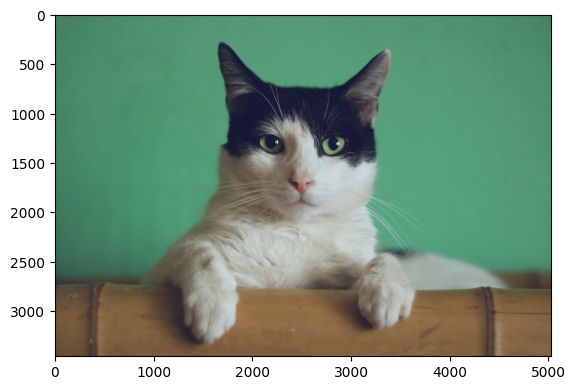

In [ ]:
img = Image.open('cat.jpg')
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])

# Expand mu & sigma to match image size
# YOUR CODE HERE
mu = mu.view(3,1,1)
sigma = sigma.view(3,1,1)

# compute the normalized image with mean ImageNet image
img = torch.Tensor(img)
img = (img - mu) / sigma

# Loding pre-trained VGG
vgg16_new.eval()

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img).to(device)
with torch.no_grad():
   y = vgg16_new(x) # TODO calcul forward
y = y.cpu().numpy()

# Get prediction (i.e., ImageNet class label)
predicted_class = np.argmax(y)
print('Predicted class:', imagenet_classes[predicted_class])

- ### Look into methods for dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

def main_relu6_dr(path="15SceneData", batch_size=8, C=1.0, n_components=None):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu6')
    model = VGG16relu6()

    model.eval()
    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    print("(PCA前) X_train shape:", X_train.shape)

    # Dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    print("(PCA后) X_train shape:", X_train.shape)
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    start_time = time.time()
    svm = LinearSVC(C=C)
    svm.fit(X_train, y_train)
    end_time = time.time()
    print(f'SVM training completed in {end_time - start_time:.2f} seconds')

    accuracy = svm.score(X_test, y_test)

    print('Accuracy = %f' % accuracy)

In [ ]:
# 不使用PCA降维
main_relu6_dr("15SceneData", 8, 3)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu6
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
(PCA前) X_train shape: (1496, 4096)
(PCA后) X_train shape: (1496, 4096)
Apprentissage des SVM
SVM training completed in 1.08 seconds
Accuracy = 0.908847


In [ ]:
# PCA降维为1200
main_relu6_dr("15SceneData", 8, 3, 1200)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu6
Récupération des données
Feature extraction
Batch 000/187
Batch 050/187
Batch 100/187
Batch 150/187
Batch 000/373
Batch 050/373
Batch 100/373
Batch 150/373
Batch 200/373
Batch 250/373
Batch 300/373
Batch 350/373
(PCA前) X_train shape: (1496, 4096)
(PCA后) X_train shape: (1496, 1200)
Apprentissage des SVM
SVM training completed in 1.77 seconds
Accuracy = 0.910188
